In [65]:
import sys
import math
from collections import defaultdict, OrderedDict, Counter
import pprint as pp
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from __future__ import division

%matplotlib inline

In [66]:
input_file = 't0_cpu_x.csv'
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['jeditaskid', 'atlrel', 'cputype', 'njobs',
                                                              'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
                                                              'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [67]:
grouped = df.groupby(['jeditaskid', 'cputype'], as_index=False, sort=False)

data = defaultdict(OrderedDict)
for (j, s), g in grouped:
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[j][s] = (x, y)

In [68]:
# Remove from data tasks with only one site
for (k, v) in data.items():
    if len(v) == 1:
        del data[k]

In [69]:
# Map cpus to integers
i = -1
sites = set()
smap = dict()
for (k, v) in data.items():
    for s in v.keys():
        if s not in sites:
            i += 1
            smap[s] = i
            sites.add(s)
        data[k][smap[s]]= data[k][s]
        del data[k][s]

nsites = len(smap)
print 'There are %s sites in the fit' % nsites

There are 6 sites in the fit


In [70]:
# Map tasks to integers
tasks = set(data.keys())
tmap = dict()
i = 0
for x in tasks:
    tmap[x] = i
    i += 1

In [71]:
ntask = len(data)
nsite = len(smap)
a_ini = np.zeros(ntask)
for j, task in data.items():
    nt = tmap[j]
    a_ini[nt] = np.mean([b[0] for b in task.values()])
x_ini = np.hstack((a_ini, np.ones(nsite)))

In [72]:
print "Tasks: ", ntask
print "Sites/CPUs: ", nsite
print "Sum of initial values: ", np.sum(x_ini)

Tasks:  348
Sites/CPUs:  6
Sum of initial values:  4887.46803916


In [73]:
def func_val(x):
    a = x[:ntask]
    k = x[ntask:]
    total = 0.
    for j, task in data.items():   # looping on tasks
        nt = tmap[j]
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([b[0] for b in task.values()])
        f_term = 1. / a[nt]**2 * (v * kf - a[nt])**2
        delta = np.sum(f_term)
        total += delta
    return total

In [74]:
def grad_val(x):
    a = x[:ntask]
    k = x[ntask:]
    g = np.zeros(len(x))
    for j, task in data.items():
        g_a = 0.
        nt = tmap[j]
        for i in task.keys():
            (v, _) = task[i]
            g_a += -2 * v * k[i] / a[nt]**2 * (v * k[i] / a[nt] - 1)
            g_k = 2 / a[nt]**2 * v * (k[i] * v - a[nt])
            g[ntask + i] += g_k
        g[nt] = g_a
    return g

In [75]:
def hess_val(x):
    a = x[:ntask]
    k = x[ntask:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    for t, task in data.items():
        h = 0.
        nt = tmap[t]
        for i in task.keys():
            (v, _) = task[i]
            h += 2 / a[nt]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[nt])
            diag[ntask + i] += 2 * v**2 / a[nt]**2
            H[nt][ntask+i] = H[ntask+i][nt] = -2 * v / a[nt]**2 * ( 2 * v * k[i] / a[nt] - 1)
        diag[nt] = h
    H = H + np.diag(diag)
    return H

In [76]:
func_val(x_ini)

32.74684008920098

In [77]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

1.19209046771e-05


In [78]:
result_val = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 7.411724
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 41
         Hessian evaluations: 20


In [79]:
k_val = result_val.x[ntask:]

In [92]:
final = dict()
for (k, v) in smap.items():
    final[k] = k_val[v]
    print k, k_val[v]

AMD_Opteron(TM)_Processor_6276 0.607692173706
Intel(R)_Xeon(R)_CPU_E5-2650_0_@_2.00GHz 0.701772739664
Intel(R)_Xeon(R)_CPU_E5-2650_v2_@_2.60GHz 1.10388331758
Intel(R)_Xeon(R)_CPU_E5-2630L_0_@_2.00GHz 0.859444395579
Intel(R)_Xeon(R)_CPU_E5-2630_v3_@_2.40GHz 1.19456241186
Intel(R)_Xeon(R)_CPU___________L5520__@_2.27GHz 0.719852427009


In [45]:
x = result_val.x
points = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v * x[ntask+i] / x[nt]
        points.append(p)

The value of S is: 0.096


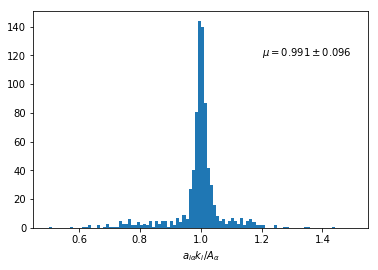

In [82]:
bins = 100
xrange = (0.5, 1.5)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points, bins=bins, range=xrange)
n = len(points)
mu = np.mean(points)
sigma = np.std(points)
plt.xlabel(r'$a_{i\alpha}k_i/A_\alpha$')
plt.text(1.2, 120., r'$\mu=%.3f\pm%.3f$' % (mu, sigma))
S = sigma
print 'The value of S is: %.3f' % S

In [83]:
y, x = np.histogram(points, bins=bins, range=xrange)
y = np.divide(y, np.float(np.sum(y))*binsize)

0.995563423789 0.0217654275238
The value of S is: 0.022


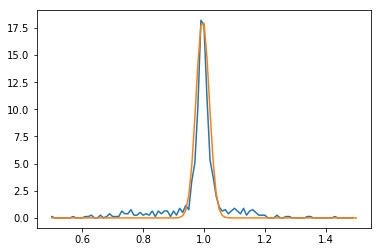

In [84]:
def f(x, m, s):
    return 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

plt.plot(x[:-1], y)
(m, s), _ = optimize.curve_fit(f, x[:-1], y)
print m, s
plt.plot(x, f(x, m, s))
S1 = s
print 'The value of S is: %.3f' % S1

0.995381310881 0.0166001916627 -5105576.72245 0.744362773
The value of S is: 2581409.213


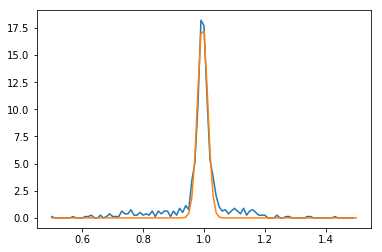

In [85]:
def f2(x, m, s1, s2, n):
    return n / (s1 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s1**2)) + \
        (1 - n) / (s2 * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s2**2))
 
plt.plot(x[:-1], y)
(m, s1, s2, n), _ = optimize.curve_fit(f2, x[:-1], y, (1., 0.1, 1., 1.))
print m, s1, s2, n
plt.plot(x, f2(x, m, s1, s2, n))
S2 = np.sqrt(n * s1**2 + (1 - n) * s2**2)
print 'The value of S is: %.3f' % S2

In [86]:
x = result_val.x
points2 = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v / a_ini[nt]
        points2.append(p)

The value of S is: 0.203


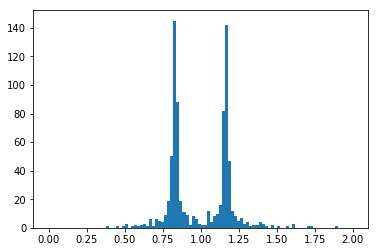

In [87]:
bins = 100
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points2, bins=bins, range=xrange)
n = len(points2)
mu = np.mean(points2)
sigma = np.std(points2)
print 'The value of S is: %.3f' % sigma

In [52]:
x = result_val.x
a = x[:ntask]
k = x[ntask:]
k_err = np.zeros_like(k)
c = 0
for t, task in data.items():
    nt = tmap[t]
    c += len(task)
    for i in task.keys():
        (v, _) = task[i]
        k_err[i] += v**2 / a[nt]**2
k_err = S / np.sqrt(k_err)

In [53]:
deg = c - len(x_ini)
chi2r = func_val(result_val.x) / S**2 / deg
print 'Degrees of freedom: %d' % deg
print 'The value of the reduced chi2 is: %.3f' % chi2r
print 'Standard deviation of reduced chi2: %.3f' % (1. / np.sqrt(2. * deg))

Degrees of freedom: 441
The value of the reduced chi2 is: 1.820
Standard deviation of reduced chi2: 0.034
